Dataset shape: (100, 203)
Missing values before imputation:
metabolite_1_metabo      14
metabolite_2_metabo      15
metabolite_3_metabo      12
metabolite_4_metabo      15
metabolite_5_metabo      16
                         ..
metabolite_96_metabo     19
metabolite_97_metabo     15
metabolite_98_metabo     21
metabolite_99_metabo     15
metabolite_100_metabo    15
Length: 100, dtype: int64
All missing values have been imputed.

Training: RandomForest
               precision    recall  f1-score   support

non-responder       0.50      0.60      0.55        10
    responder       0.50      0.40      0.44        10

     accuracy                           0.50        20
    macro avg       0.50      0.50      0.49        20
 weighted avg       0.50      0.50      0.49        20


Training: LogisticRegression
               precision    recall  f1-score   support

non-responder       0.58      0.70      0.64        10
    responder       0.62      0.50      0.56        10

     accuracy 

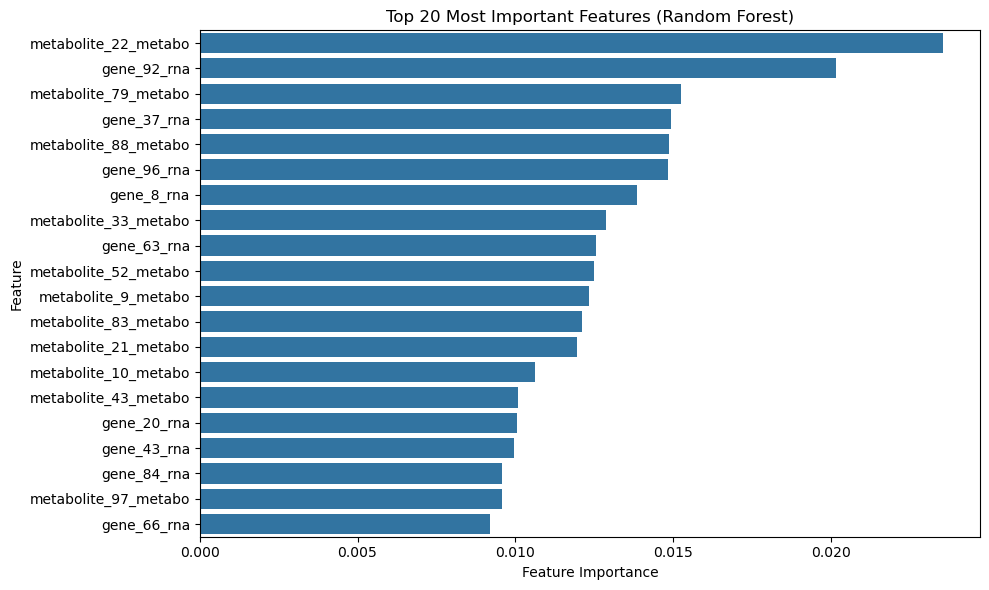

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 2. Load integrated dataset
df = pd.read_csv("../data/processed/integrated_dataset.csv", index_col=0)
print("Dataset shape:", df.shape)

# 3. Preprocessing
X = df.drop(columns=["outcome"])
y = df["outcome"]

# Drop samples with missing labels
mask = y.notna()
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

# Encode categorical column
if "sex" in X.columns:
    X["sex"] = X["sex"].map({"M": 0, "F": 1})

# Convert all columns to numeric (coerce non-convertible to NaN)
X = X.apply(pd.to_numeric, errors='coerce')

# Keep only numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Impute missing values with column means
print("Missing values before imputation:")
print(X_numeric.isna().sum()[X_numeric.isna().sum() > 0])

X_numeric = X_numeric.fillna(X_numeric.mean())

assert X_numeric.isna().sum().sum() == 0, "Missing values remain after imputation."
print("All missing values have been imputed.")

# 4. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Model training
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

trained_models = {}
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    trained_models[name] = model

# 7. Save models
os.makedirs("../models", exist_ok=True)
for name, model in trained_models.items():
    joblib.dump(model, f"../models/{name.lower()}_model.pkl")

print("Models have been saved successfully.")

# 8. Feature importance (Random Forest)
rf_model = trained_models["RandomForest"]
importances = rf_model.feature_importances_
top_indices = importances.argsort()[::-1][:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[top_indices], y=X_numeric.columns[top_indices])
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
